# Deep learning

In [1]:
%load_ext autoreload
%autoreload 2

import tasks.data
import tasks.torch_train_eval
import tasks.adaptive_train_eval
import tasks.calibration

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive")

FINETUNE_MODEL = False
TRAIN_UNSUPERVISED_MODEL = False
FINETUNE_SEMI_SUPERVISED_MODEL = False
TRAIN_SEMI_SUPERVISED_MODEL = True

RANDOM_SEED = 42
BATCH_SIZE = 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Modern Office Dataset

In [2]:
import imageio.v2 as imageio
from torchvision.transforms import v2


def resnet_preprocessor(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image for ResNet model.

    :param numpy.ndarray image: The input image.
    :return: Preprocessed image.
    :rtype: numpy.ndarray
    """
    preprocess = torchvision.transforms.Compose(
        [    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            v2.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    image = preprocess(image)
    return image


def image_read_func(image_path):
    return imageio.imread(image_path, pilmode='RGB')


In [3]:
source_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = tasks.data.train_val_test_split(
    source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
def create_padded_dataloader(
    dataset: tasks.data.ImageDataset,
    shuffle: bool = True,
    sampler = None
):
    # sampler and shuffle are mutually exclusive
    if sampler is None:
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=shuffle,
            collate_fn=tasks.data.collate_pad,
        )
    else:
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            sampler=sampler,
            collate_fn=tasks.data.collate_pad,
        )


source_train_loader = create_padded_dataloader(source_train_dataset, shuffle=True)
source_val_loader = create_padded_dataloader(source_val_dataset, shuffle=False)
source_test_loader = create_padded_dataloader(source_test_dataset, shuffle=False)

In [5]:
import pickle


def try_load_weights(model, weights_path: str):
    try:
        model.load_state_dict(torch.load(weights_path))
    except:
        print("No weights found in path ", weights_path)
    return model


def try_load_history(history_path):
    try:
        with open(history_path, 'rb') as handle:
            history = pickle.load(handle)
    except:
        print("No history found in path ", history_path)
        history = None

    return history

In [6]:
target_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
    label_encoder=source_dataset.label_encoder # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = tasks.data.train_val_test_split(
    target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
)

target_train_loader = create_padded_dataloader(target_train_dataset, shuffle=True)
target_test_loader = create_padded_dataloader(target_test_dataset, shuffle=False)

  0%|          | 0/31 [00:00<?, ?it/s]

In [7]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
unlabeled_dataset.load_from_image_dataset(target_train_dataset)

source_history = try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "source_history.pickle"))
target_history = try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "target_history.pickle"))

In [8]:
to_be_unlabeled_dataset, labeled_dataset = tasks.data.stratified_split(
    target_train_dataset, test_size=0.2
)

len(unlabeled_dataset), len(labeled_dataset), len(target_train_dataset)

(556, 112, 556)

In [9]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=labeled_dataset.parser_func,
    preprocessing_func=labeled_dataset.preprocessing_func,
)
unlabeled_dataset.load_from_image_dataset(to_be_unlabeled_dataset)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset.add(sample_img, sample_label)

len(labeled_dataset), len(source_train_dataset)

(2224, 2112)

## Source-only model

In [10]:
import torchinfo

def get_default_model():
    return torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
    ).to(device)

model = get_default_model()

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [2, 1000]                 --
├─Conv2d: 1-1                            [2, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 150, 150]         128
├─ReLU: 1-3                              [2, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [2, 64, 75, 75]           --
├─Sequential: 1-5                        [2, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [2, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [2, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [2, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [2, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [2, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [2, 64, 75, 75]           --
│

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)

In [26]:
history = try_load_history(os.path.join(FINETUNED_MODEL_DIR, "history.pickle"))


if FINETUNE_MODEL:
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_MODEL_DIR,
        num_epochs=1,
        patience=5,
        warmup_period=1,
        previous_history=history
    )

model = try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

In [ ]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

In [ ]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [30]:
def classification_results(model, dataloader):
    actual, predicted = tasks.torch_train_eval.test(model, dataloader, device)
    class_names = target_dataset.label_encoder.classes_

    print(
        sklearn.metrics.classification_report(
            actual,
            predicted,
            zero_division=0,
            target_names=class_names,
            labels=np.arange(0, len(class_names), 1),
        )
    )

    cf_matrix = sklearn.metrics.confusion_matrix(
        actual, predicted, labels=np.arange(0, len(class_names), 1)
    )
    display = sklearn.metrics.ConfusionMatrixDisplay(
        confusion_matrix=cf_matrix, display_labels=class_names
    )
    display.plot()
    plt.xticks(rotation=90)
    plt.show()

  0%|          | 0/142 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         7
            bike       0.10      0.60      0.17         5
     bike_helmet       0.00      0.00      0.00         7
        bookcase       0.50      0.14      0.22         7
          bottle       0.00      0.00      0.00         4
      calculator       0.00      0.00      0.00         8
      desk_chair       0.38      0.90      0.53        10
       desk_lamp       1.00      0.25      0.40         8
desktop_computer       0.20      0.85      0.32        13
    file_cabinet       0.00      0.00      0.00        10
      headphones       0.20      0.40      0.27         5
        keyboard       0.00      0.00      0.00        17
 laptop_computer       0.00      0.00      0.00        13
     letter_tray       0.14      0.67      0.24         6
    mobile_phone       0.36      0.56      0.43         9
         monitor       0.00      0.00      0.00         9
           mo

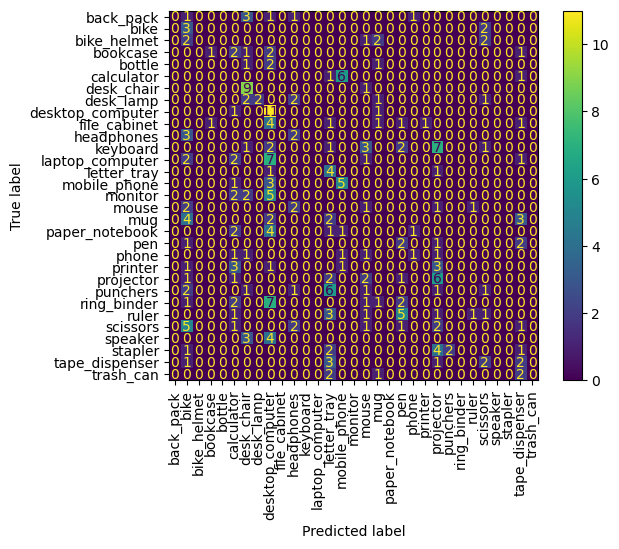

In [31]:
classification_results(model, source_test_loader)

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.50      0.50      0.50         2
     bike_helmet       0.00      0.00      0.00         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.20      0.25      0.22         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.03      1.00      0.05         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

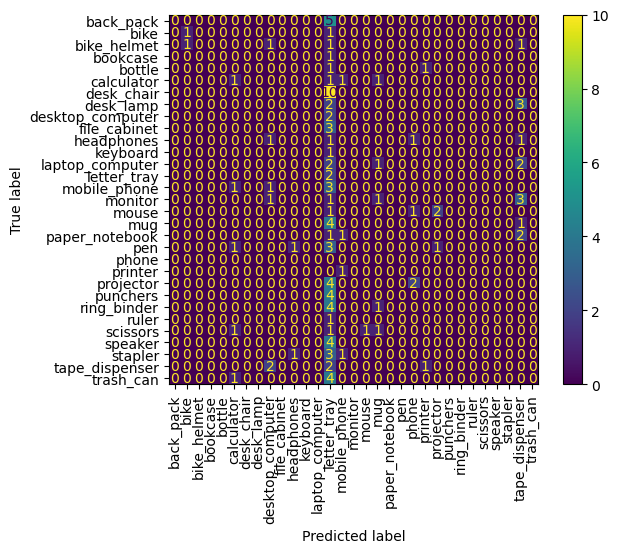

In [32]:
classification_results(model, target_test_loader)

## Unsupervised Domain Adaptation

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af

https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results

https://www.sciencedirect.com/science/article/abs/pii/S1077314222001102

In [33]:
if TRAIN_UNSUPERVISED_MODEL:
    model, source_history, target_history = (
        tasks.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=source_train_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: create_padded_dataloader(
                dataset,
                sampler=sampler,
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=20,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )

model = try_load_weights(model, os.path.join(UNSUPERVISED_MODEL_DIR, "model.pt"))

In [ ]:
plt.plot(np.array(range(len(target_history["train_acc"]))), target_history["train_acc"])
plt.plot(np.array(range(len(target_history["val_acc"]))), target_history["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training loss")
plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.14      0.50      0.22         2
     bike_helmet       0.00      0.00      0.00         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.00      0.00      0.00         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.09      0.50      0.15         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.03      0.40      0.06         5
     letter_tray       1.00      0.50      0.67         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

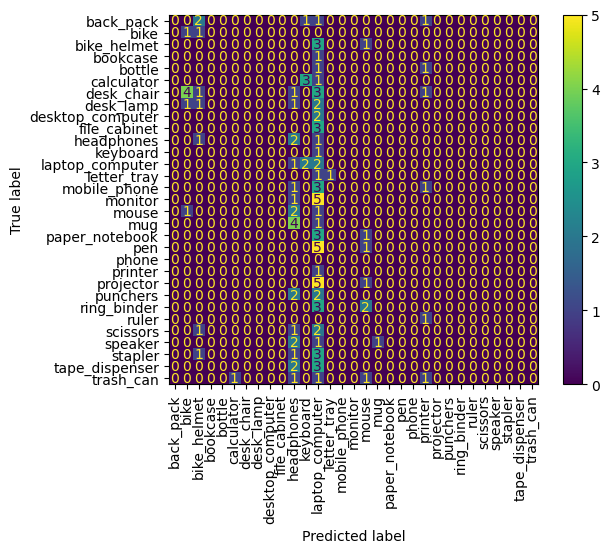

In [34]:
classification_results(model, target_test_loader)

## Semi-supervised domain adaptation

In [41]:
if FINETUNE_SEMI_SUPERVISED_MODEL:
    model, history = tasks.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        #train_dataloader=source_train_loader,
        train_dataloader=create_padded_dataloader(labeled_dataset, shuffle=True),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history
    )

model = try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR, "model.pt"))

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      0.80      0.89         5
            bike       1.00      1.00      1.00         2
     bike_helmet       0.00      0.00      0.00         4
        bookcase       0.00      0.00      0.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      0.50      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       1.00      0.40      0.57         5
desktop_computer       0.20      0.50      0.29         2
    file_cabinet       1.00      0.33      0.50         3
      headphones       0.50      0.25      0.33         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.20      0.33         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.29      0.40      0.33         5
         monitor       0.00      0.00      0.00         6
           mo

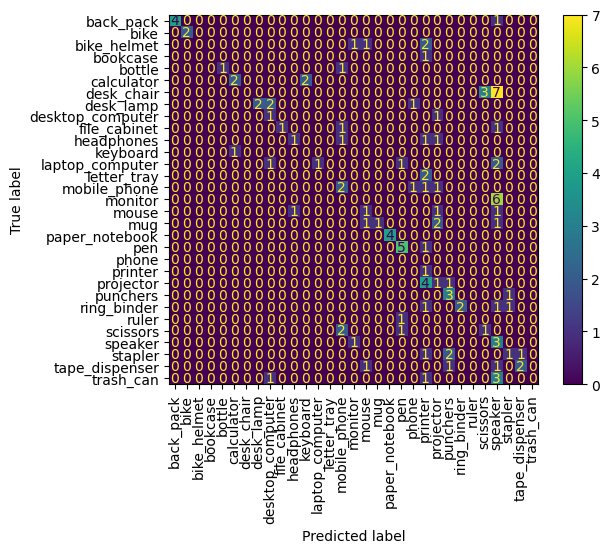

In [42]:
classification_results(model, target_test_loader)

In [12]:
if TRAIN_SEMI_SUPERVISED_MODEL:
    model, source_history, target_history, label_history = (
        tasks.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: create_padded_dataloader(
                dataset,
                sampler=sampler,
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR,
            num_epochs=100,
            pseudo_sample_period=5,
            rho=4,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )

model = try_load_weights(model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR, "model.pt"))

Epoch 0/99
----------


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      0.80      0.89         5
            bike       1.00      1.00      1.00         2
     bike_helmet       0.00      0.00      0.00         4
        bookcase       0.00      0.00      0.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      0.50      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       1.00      0.40      0.57         5
desktop_computer       0.20      0.50      0.29         2
    file_cabinet       1.00      0.33      0.50         3
      headphones       0.50      0.25      0.33         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.20      0.33         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.29      0.40      0.33         5
         monitor       0.00      0.00      0.00         6
           mo

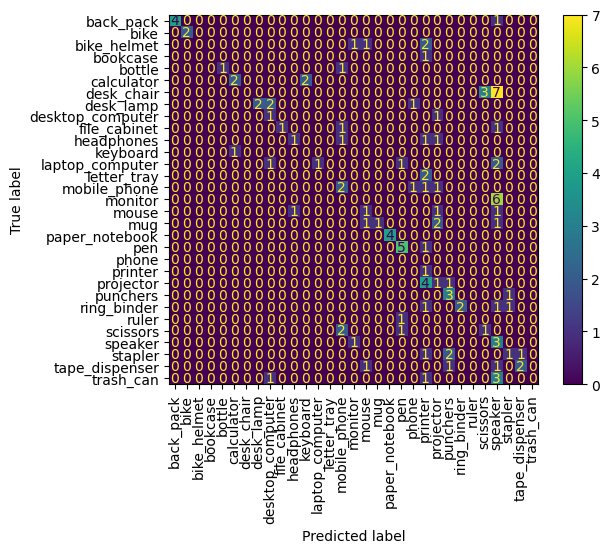

In [44]:
classification_results(model, target_test_loader)

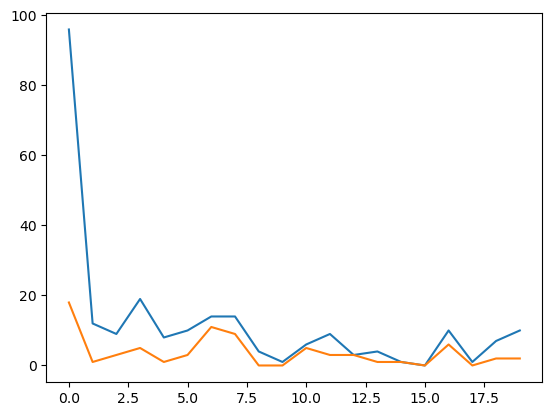

In [58]:
def count_misclassifications(label_history, encodings):
    misclassifications = []

    for history in label_history:
        misclassified_count = 0

        for file_path, class_id in history:
            # Extract class name from file path
            class_name = file_path.split('/')[-2]

            # Map class name to class ID using encodings dictionary
            predicted_class_id = [k for k, v in encodings.items() if v == class_name][0]

            # Check if class IDs are different
            if predicted_class_id != class_id:
                misclassified_count += 1

        misclassifications.append(misclassified_count)

    return misclassifications


def plot_label_history(label_history, encodings):
    misclassifications = count_misclassifications(label_history, encodings)
    label_counts = [len(x) for x in label_history]
    plt.plot(label_counts)
    plt.plot(misclassifications)
    plt.show()


encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

plot_label_history(label_history, encodings)

## Dustbin